# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [1]:
# Import all necessary packages and modules
from dps_lake_model import lake_model
from ema_workbench import (RealParameter, ScalarOutcome, Constant, Constraint,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy, Scenario)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.evaluators import LHS
from lakemodel_function import lake_problem
from ema_workbench.analysis import prim
from SALib.analyze import sobol
ema_logging.log_to_stderr(ema_logging.INFO)

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (HyperVolume,EpsilonProgress)
from ema_workbench import Constraint, Policy, save_results, load_results

In [2]:
# define the lake model and its metrics
lake_model = Model('Lakemodel', function=lake_model)

lake_model.uncertainties = [RealParameter('b',0.01,0.05),
                           RealParameter('q',2.0,4.5),
                           RealParameter('mean',0.01,0.05),
                           RealParameter('stdev',0.001,0.005),
                           RealParameter('delta',0.93,0.99)]

lake_model.levers = [RealParameter('c1',-2.0,2.0),
                           RealParameter('c2',-2.0,2.0),
                           RealParameter('r1',0.0,2.0),
                           RealParameter('r2',0.0,2.0),
                           RealParameter('w1',0.0,1.0)]

lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),EpsilonProgress()]

In [3]:
results = load_results('results/selected_results.tar.gz')
df= results

[MainProcess/INFO] results loaded succesfully from C:\Users\ambro\PycharmProjects\EPA1361\lab_sessions\Week 5-6 - robustness and direct search\results\selected_results.tar.gz


In [4]:
results
#with MultiprocessingEvaluator(lake_model) as evaluator:
experiments, Results = results


In [5]:
experiments

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.028993,0.973444,0.022909,2.187052,0.004248,0.251189,0.466588,0.416626,1.435007,0.986797,0,0,Lakemodel
1,0.027536,0.946723,0.035596,2.617213,0.003790,0.251189,0.466588,0.416626,1.435007,0.986797,1,0,Lakemodel
2,0.035567,0.982854,0.045683,4.175675,0.001463,0.251189,0.466588,0.416626,1.435007,0.986797,2,0,Lakemodel
3,0.047810,0.987861,0.016886,2.733429,0.001319,0.251189,0.466588,0.416626,1.435007,0.986797,4,0,Lakemodel
4,0.025888,0.944292,0.032478,4.089179,0.002928,0.251189,0.466588,0.416626,1.435007,0.986797,6,0,Lakemodel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11979,0.044053,0.964810,0.042461,3.717552,0.001709,0.312226,0.777886,0.436954,1.601438,0.915666,995,13,Lakemodel
11980,0.035661,0.965292,0.047382,3.200350,0.003381,0.312226,0.777886,0.436954,1.601438,0.915666,996,13,Lakemodel
11981,0.036395,0.966042,0.012099,2.403512,0.003981,0.312226,0.777886,0.436954,1.601438,0.915666,997,13,Lakemodel
11982,0.038332,0.978097,0.031767,3.792047,0.003459,0.312226,0.777886,0.436954,1.601438,0.915666,998,13,Lakemodel


In [6]:
df_r = pd.DataFrame(Results)
df_r

,max_P,utility,inertia,reliability
0,36.090625,1.258633,0.9732,0.0100
1,38.041126,0.615564,0.9713,0.0100
2,30.991878,1.741175,0.9700,0.0513
3,23.045028,2.073324,0.9708,0.0300
4,39.503512,0.537296,0.9720,0.0574
...,...,...,...,...
11979,25.495845,0.945777,0.9733,0.0400
11980,31.032057,0.987308,0.9720,0.0200
11981,29.497866,0.999761,0.9710,0.0100
11982,28.625876,1.428167,0.9750,0.0492


In [7]:
df_r = pd.DataFrame(Results)

List =['max_P','utility','inertia','reliability']
List2 = []
counter = 1

for i in List:
    if i == 'max_P':    
        values = df_r[i].max()
    else: 
        values = df_r[i].min()
        
    #index_e = np.random.choice(Results.loc[df_r[i]==values].index)
    #print('\n',index_e)
    #line = select.experiments.iloc[index_e]
    #List2.append(Scenario('SS'+str(counter)), b=line['b'], q=line['q'], mean=line['l'], delta=line['delta'], stdev=0.01)

    counter += 1

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


In [8]:

List3 = []

for index_e in [2655, 12, 1, 2]:
    line = experiments.iloc[index_e]
    List3.append(Scenario('SS'+str(counter), b=line['b'], q=line['q'], mean=line['mean'], delta=line['delta'], stdev=line['stdev']))


List3 


[Scenario({'b': 0.0101343696005932, 'q': 3.629988016886072, 'mean': 0.0493720793085834, 'delta': 0.9818361130069028, 'stdev': 0.0013288322021815}),
 Scenario({'b': 0.0417807852062619, 'q': 2.1795020152185773, 'mean': 0.015118625443797, 'delta': 0.9864489675163558, 'stdev': 0.0014034679448051}),
 Scenario({'b': 0.0275363162126696, 'q': 2.6172132967712782, 'mean': 0.035595667375932, 'delta': 0.9467234545022803, 'stdev': 0.0037899981012042}),
 Scenario({'b': 0.0355670282853716, 'q': 4.175674795845754, 'mean': 0.0456828196956158, 'delta': 0.9828540400273732, 'stdev': 0.0014634261572398})]

In [9]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results1, convergence1 = evaluator.optimize(nfe=1000, searchover='levers', scenarios=List3,
                                    epsilons=[0.02, 0.02, 0.02, 0.02],
                                    convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 497/1000 nfe
[MainProcess/INFO] generation 10: 992/1000 nfe
[MainProcess/INFO] optimization completed, found 49 solutions
[MainProcess/INFO] terminating pool


## Re-evaluate under deep uncertainty

1. Combine the pareto set of solutions found for each scenario. 
2.Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size).
3.As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [10]:
results1

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.832733,-0.126328,1.786422,0.958880,0.446671,2.283787,1.469135,0.9836,0.1605
1,-0.459194,1.786736,1.956128,1.140965,0.012774,2.191728,1.015093,0.9900,0.0700
2,-1.453631,-1.890666,0.601770,0.738785,0.372822,2.283661,1.734761,0.9900,0.0700
3,-0.164850,0.565409,0.619059,1.673227,0.085290,2.283435,0.710586,0.9821,0.6593
4,-0.236383,0.770743,1.668243,0.506250,0.990905,2.283874,1.094975,0.9841,0.3449
5,-0.154870,1.779845,1.956128,1.140965,0.012774,2.032851,0.754807,0.9900,0.0700
6,-0.154798,1.130032,1.698755,1.822827,0.798195,2.283815,1.157216,0.9813,0.3065
7,-0.955874,-0.138534,1.118240,1.583020,0.026944,2.283827,1.313016,0.9884,0.2205
8,-0.167414,0.687308,1.965498,1.505408,0.085290,0.230390,0.544928,0.9900,1.0000
9,-0.168571,1.343260,1.698755,1.822827,0.895891,2.283761,1.230624,0.9830,0.2682


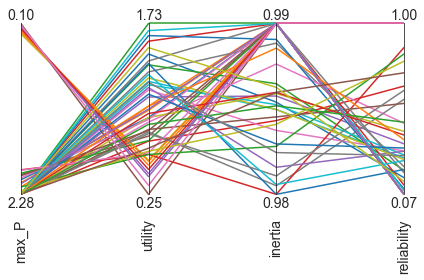

In [11]:
results1_copy = results1.copy()

outcomesbig001 = results1_copy.drop(columns=['c1','c2','r1','r2','w1'])

limits = parcoords.get_limits(outcomesbig001)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomesbig001)
axes.invert_axis('max_P') 
plt.show()

In [12]:
levers = results1.copy()
levers.drop(columns=['max_P','utility','inertia','reliability'])

,c1,c2,r1,r2,w1
0,0.832733,-0.126328,1.786422,0.958880,0.446671
1,-0.459194,1.786736,1.956128,1.140965,0.012774
2,-1.453631,-1.890666,0.601770,0.738785,0.372822
3,-0.164850,0.565409,0.619059,1.673227,0.085290
4,-0.236383,0.770743,1.668243,0.506250,0.990905
5,-0.154870,1.779845,1.956128,1.140965,0.012774
6,-0.154798,1.130032,1.698755,1.822827,0.798195
7,-0.955874,-0.138534,1.118240,1.583020,0.026944
8,-0.167414,0.687308,1.965498,1.505408,0.085290
9,-0.168571,1.343260,1.698755,1.822827,0.895891


In [13]:
dictsolutions = results1[['c1','c2','r1','r2','w1']].to_dict(orient = 'records')
policy_options = []
for i in range(len(dictsolutions)):
    policy_options.append(Policy(str(i),**dictsolutions[i]))

In [14]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments_trees, outcomes_trees = evaluator.perform_experiments(scenarios = 10, policies=policy_options, uncertainty_sampling=LHS)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 49 policies * 1 model(s) = 490 experiments
[MainProcess/INFO] 49 cases completed
[MainProcess/INFO] 98 cases completed
[MainProcess/INFO] 147 cases completed
[MainProcess/INFO] 196 cases completed
[MainProcess/INFO] 245 cases completed
[MainProcess/INFO] 294 cases completed
[MainProcess/INFO] 343 cases completed
[MainProcess/INFO] 392 cases completed
[MainProcess/INFO] 441 cases completed
[MainProcess/INFO] 490 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
print(policy_options)

[Policy({'c1': 0.8327325638310912, 'c2': -0.12632760890638606, 'r1': 1.786421949253863, 'r2': 0.9588802766838389, 'w1': 0.44667072313752154}), Policy({'c1': -0.4591942064367399, 'c2': 1.7867358166086817, 'r1': 1.956128274998279, 'r2': 1.1409647604974507, 'w1': 0.012773868924490839}), Policy({'c1': -1.4536313244225418, 'c2': -1.890665825307941, 'r1': 0.6017696540840187, 'r2': 0.7387854692809667, 'w1': 0.37282161649801726}), Policy({'c1': -0.16485003951028726, 'c2': 0.5654085004523948, 'r1': 0.6190593706069881, 'r2': 1.6732273193231624, 'w1': 0.08529042465395789}), Policy({'c1': -0.23638348049635516, 'c2': 0.7707429035322741, 'r1': 1.6682433561303136, 'r2': 0.506250274184735, 'w1': 0.9909053651730785}), Policy({'c1': -0.1548702026415576, 'c2': 1.779845433126276, 'r1': 1.956128274998279, 'r2': 1.1409647604974507, 'w1': 0.012773868924490839}), Policy({'c1': -0.15479789602476884, 'c2': 1.1300323361908604, 'r1': 1.6987549207387382, 'r2': 1.8228267943782952, 'w1': 0.798195258583173}), Policy(

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [16]:
outcomesdf = pd.DataFrame(outcomes_trees)

outcomesdf[['scenario','policy']] = experiments_trees[['scenario','policy']]

outcomesdf[['max_P_regret','utility_regret','inertia_regret','reliability_regret']] = np.nan

for i,row in outcomesdf.iterrows():
    outcomesdf.iloc[i,6] = outcomesdf.loc[outcomesdf['scenario']==row['scenario']]['max_P'].max()-row['max_P']
    outcomesdf.iloc[i,7] = outcomesdf.loc[outcomesdf['scenario']==row['scenario']]['utility'].max()-row['utility']
    outcomesdf.iloc[i,8] = outcomesdf.loc[outcomesdf['scenario']==row['scenario']]['inertia'].max()-row['inertia']
    outcomesdf.iloc[i,9] = outcomesdf.loc[outcomesdf['scenario']==row['scenario']]['reliability'].max()-row['reliability']

In [17]:
outcomesdf.groupby('policy').max()


,max_P,utility,inertia,reliability,scenario,max_P_regret,utility_regret,inertia_regret,reliability_regret
policy,,,,,,,,,
0,59.405548,2.039387,0.9800,0.0502,9,0.619357,0.121537,0.0200,0.0421
1,60.001550,2.124721,0.9800,0.0300,9,0.023355,0.031135,0.0127,0.0623
10,60.001554,2.122963,0.9800,0.0300,9,0.023351,0.032136,0.0137,0.0623
11,59.999847,2.123802,0.9800,0.0300,9,0.025058,0.031459,0.0128,0.0623
12,59.218079,2.012329,0.9800,0.0501,9,0.806827,0.142860,0.0186,0.0422
13,59.538356,2.064132,0.9800,0.0500,9,0.486549,0.094494,0.0200,0.0423
14,58.108598,1.832415,0.9797,0.0707,9,1.916307,0.357123,0.0197,0.0302
15,57.660773,1.768432,0.9744,0.0923,9,2.364132,0.409298,0.0200,0.0074
16,58.838530,1.939541,0.9799,0.0709,9,1.186375,0.246063,0.0195,0.0214


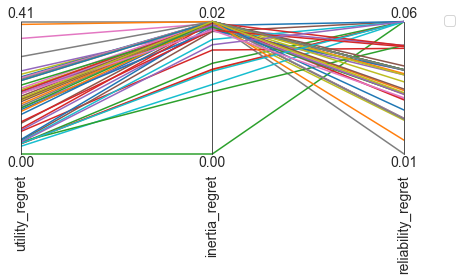

In [18]:
data = outcomesdf[['utility_regret','inertia_regret','reliability_regret','policy']].groupby('policy').max()

limits = parcoords.get_limits(data)
axes = parcoords.ParallelAxes(limits)
axes.plot(data)
axes.legend()
plt.show()

In [19]:
data.sort_values('utility_regret', ascending=True).head(5)

,utility_regret,inertia_regret,reliability_regret
policy,,,
2,0.000000,0.0000,0.0623
26,0.023607,0.0105,0.0623
1,0.031135,0.0127,0.0623
11,0.031459,0.0128,0.0623
44,0.032015,0.0125,0.0623


In [20]:
data.sort_values('inertia_regret', ascending=True).head(5)

,utility_regret,inertia_regret,reliability_regret
policy,,,
2,0.000000,0.0000,0.0623
29,0.037667,0.0094,0.0525
26,0.023607,0.0105,0.0623
44,0.032015,0.0125,0.0623
1,0.031135,0.0127,0.0623


In [21]:
data.sort_values('reliability_regret', ascending=True).head(5)

,utility_regret,inertia_regret,reliability_regret
policy,,,
15,0.409298,0.0200,0.0074
46,0.400545,0.0200,0.0131
16,0.246063,0.0195,0.0214
42,0.230156,0.0200,0.0219
18,0.237948,0.0200,0.0220


**Conclusion**

Sorting to find the polcies with the least regret in terms of utility and inertia yields policy number 23. After, is policy 9. Interestingly enough, ultiity and inertia regret concur.

Moreover, reliablity regret minimized yields policy 1. This is interesting becuase the  